# Gated Recurrent Unit Network

We're going to build a Gated Recurrent Unit from scratch using just numpy and look at the math behind it.

## Imports

In [1]:
import numpy as np
from abc import ABC, abstractmethod
import tensorflow as tf

C:\Users\mvp\AppData\Roaming\Python\Python37\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Download Dataset

We will be using a text dataset to test the GRU.

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
data = open(path_to_file, 'rb').read().decode(encoding='utf-8')
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

data has 1115394 characters, 65 unique.


Great! Now that we have our one-hot encoding dictionary in place, we can move on to the GRU!

# Introduction to Gated Recurent Units (GRUs)

GRUs are improved version of standard recurrent neural network made to solve the vanishing gradient problem. To solve the vanishing gradient problem of a standard RNN, GRU uses, so-called, update gate and reset gate. Basically, these are two vectors which decide what information should be passed to the output. The special thing about them is that they can be trained to keep information from long ago, without washing it through time or remove information which is irrelevant to the prediction.
To explain the mathematics behind that process we will examine a single unit from the following recurrent neural network:

![alt_image](https://miro.medium.com/max/1400/1*7oE-4Wg6bZ7u8yDf5cjJPA.png)

First, let’s introduce the notations:
![alt_image](https://miro.medium.com/max/1400/1*qx5uUSVgL_QCvsJ_yM2pMA.png)



## 1. Update gate
We start with calculating the update gate z_t for time step t using the formula:

![alt_image](https://miro.medium.com/max/1400/1*o7NzuF8w0H7qybG8Fn-Shw.png)

When x_t is plugged into the network unit, it is multiplied by its own weight W(z). The same goes for h_(t-1) which holds the information for the previous t-1 units and is multiplied by its own weight U(z). Both results are added together and a sigmoid activation function is applied to squash the result between 0 and 1.

The update gate helps the model to determine how much of the past information (from previous time steps) needs to be passed along to the future. That is really powerful because the model can decide to copy all the information from the past and eliminate the risk of vanishing gradient problem. We will see the usage of the update gate later on. For now remember the formula for z_t.



## 2. Reset gate
Essentially, this gate is used from the model to decide how much of the past information to forget. To calculate it, we use:

![alt_image](https://miro.medium.com/max/1400/1*j1j1mLIyTm97hCay4GRC_Q.png)

This formula is the same as the one for the update gate. The difference comes in the weights and the gate’s usage, which will see in a bit. As before, we plug in h_(t-1) and x_t, multiply them with their corresponding weights, sum the results and apply the sigmoid function.

## 3. Current memory content
Let’s see how exactly the gates will affect the final output. First, we start with the usage of the reset gate. We introduce a new memory content which will use the reset gate to store the relevant information from the past. It is calculated as follows:

![alt_image](https://miro.medium.com/max/1400/1*CxQBMqy8dvgJNjeJcur6pQ.png)

**1.** Multiply the input x_t with a weight W and h_(t-1) with a weight U.

**2.** Calculate the Hadamard (element-wise) product between the reset gate r_t and Uh_(t-1). That will determine what to remove from the previous time steps. Let’s say we have a sentiment analysis problem for determining one’s opinion about a book from a review he wrote. The text starts with “This is a fantasy book which illustrates…” and after a couple paragraphs ends with “I didn’t quite enjoy the book because I think it captures too many details.” To determine the overall level of satisfaction from the book we only need the last part of the review. In that case as the neural network approaches to the end of the text it will learn to assign r_t vector close to 0, washing out the past and focusing only on the last sentences.

**3.** Sum up the results of step 1 and 2.

**4.** Apply the nonlinear activation function tanh.

We do an element-wise multiplication of h_(t-1) and r_t and then sum the result with the input x_t. Finally, tanh is used to produce h’_t.


## 4. Final memory at current time step
As the last step, the network needs to calculate h_t — vector which holds information for the current unit and passes it down to the network. In order to do that the update gate is needed. It determines what to collect from the current memory content — h’_t and what from the previous steps — h_(t-1). That is done as follows:

![alt_image](https://miro.medium.com/max/1400/1*zxSTnqedwLRoicgHKYKsVQ.png)

**1.** Apply element-wise multiplication to the update gate z_t and h_(t-1).
**2.** Apply element-wise multiplication to (1-z_t) and h’_t.
**3.** Sum the results from step 1 and 2.

Let’s bring up the example about the book review. This time, the most relevant information is positioned in the beginning of the text. The model can learn to set the vector z_t close to 1 and keep a majority of the previous information. Since z_t will be close to 1 at this time step, 1-z_t will be close to 0 which will ignore big portion of the current content (in this case the last part of the review which explains the book plot) which is irrelevant for our prediction.

Following through, you can see how z_t is used to calculate 1-z_t which, combined with h’_t, produces a result. z_t is also used with h_(t-1) in an element-wise multiplication. Finally, h_t is a result of the summation of the outputs.

Now lets apply these in numpy to build the GRU.

## Activation Functions and Loss Function

Let us first define activation functions and its derivatives and also a loss function for future use 

### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def d_sigmoid(x):
    return x * (1 - x)


def relu(x):
    return np.maximum(0, x)


def d_relu(x):
    return x > 0


def tanh(x):
    return np.tanh(x)


def d_tanh(x):
    return 1 - (x ** 2)


def softmax_loss(y_prime, y):
    probs = np.exp(y_prime - np.max(y_prime, axis=1, keepdims=True))
    probs /= np.sum(probs, axis=1, keepdims=True)
    N = y_prime.shape[0]
    loss = -np.sum(np.log(probs[range(N), y])) / N
    dx = probs.copy()
    dx[range(N), y] -= 1
    return loss, dx


def logistic_loss(y_prime, y):
    N = y_prime.shape[0]
    loss = np.sum(np.square(y - y_prime) / 2) / N
    dx = -(y - y_prime)
    return loss, dx


## Optimizers

Lets write an implentation of Adagrad and Adam Optimizer algorithms

In [4]:
def adam_update(w, d, m, lr, beta1=0.9, beta2=0.999, eps=1e-8):
    m['t'] += 1

    m['m'] = beta1 * m['m'] + (1 - beta1) * d
    m['v'] = beta2 * m['v'] + (1 - beta2) * (d ** 2)

    m_ = m['m'] / (1 - beta1 ** m['t'])
    v_ = m['v'] / (1 - beta2 ** m['t'])

    return w - lr * m_ / (np.sqrt(v_) + eps)


def adagrad_update(w, d, m, lr, eps=1e-8):
    m['m'] += d * d
    return w - lr * d / np.sqrt(m['m'] + eps)

## Hyperparameters and Parameters

Let us define the hyperparameters for the network along with a parameter class to declare the weights of the network

In [5]:
EPOCHS = 10000 #Number of Training Epochs
LEARNING_RATE = 1e-3 #Learning Rate of the Network
SEQUENCE_LEN = 128 #Length of Sequence take in one batch
OUTPUT_ROUND = 1000 #Interal at which to show Output 

## Initialiation of a GRU Cell

First lets define an Abstract Base Class for a Layer and the the GRU Cell

In [6]:
class Layer(ABC):
    dropout = 1.0
    is_input = False
    is_output = False
    is_hidden = False

    @abstractmethod
    def forward(self, x):
        pass

    @abstractmethod
    def backward(self, dy):
        pass

    @abstractmethod
    def update(self, lr):
        pass

    @abstractmethod
    def predict(self, x):
        pass

In [7]:
class GruLayer(Layer):
    def __init__(self, h_size, i_size, o_size,
                 is_input, is_output, is_hidden,
                 u_type='adam', dropout=1.0, **kwargs):

        self._w, self._d, self._m = {}, {}, {}

        self.h_size = h_size
        self.i_size = i_size
        self.o_size = o_size
        self.is_ouput = is_output
        self.is_input = is_input
        self.is_hidden = is_hidden
        self.u_type = u_type
        self.dropout = dropout

        self.clip = (-2, 2)

        self.first_h = [np.zeros((self.h_size, 1), np.float32)]
        self.h = self.first_h.copy()
        self.h_predict_prev = self.first_h[0].copy()

        # for backward
        self._h_prev = self.h[-1]

        # for cache
        self.stacked_x, self.stacked_x_r, self.z, self.r, self.h_hat = [], [], [], [], []

        self._w_keys = ['w_r', 'w_z', 'w_h', 'w_y']
        self._b_keys = ['b_r', 'b_z', 'b_h', 'b_y']

        if not self.is_ouput:
            self._w_keys.remove('w_y')
            self._b_keys.remove('b_y')

        self._w, self._d, self._m = {}, {}, {}

        total_input = h_size + i_size
        for k in self._w_keys:
            if k == 'w_y':
                # dev = np.sqrt(6.0 / (o_size + h_size))
                # self._w[k] = np.random.uniform(-dev, dev, (o_size, h_size)).astype(np.float32)
                self._w[k] = np.random.randn(o_size, h_size).astype(np.float32) * np.sqrt(2.0 / (h_size))
                # self._w[k] = np.random.randn(o_size, h_size).astype(np.float32) * 0.01
                # self._w[k] = np.random.randn(o_size, h_size).astype(np.float32) * np.sqrt(2.0 / (h_size + o_size))
            else:
                # dev = np.sqrt(6.0 / (total_input + h_size))
                # self._w[k] = np.random.uniform(-dev, dev, (h_size, total_input)).astype(np.float32)
                self._w[k] = np.random.randn(h_size, total_input).astype(np.float32) * np.sqrt(2.0 / (total_input))
                # self._w[k] = np.random.randn(h_size, total_input).astype(np.float32) * 0.01
                # self._w[k] = np.random.randn(h_size, total_input).astype(np.float32) * np.sqrt(2.0 / (total_input + h_size))

        for k in self._b_keys:
            if k == 'b_y':
                self._w[k] = np.zeros((self.o_size, 1), np.float32)
            else:
                self._w[k] = np.zeros((self.h_size, 1), np.float32)

        for k in self._w_keys + self._b_keys:
            self._m[k] = {'m': 0, 'v': 0, 't': 0}
            self._d[k] = np.zeros_like(self._w[k], np.float32)

    def forward(self, x):
        self.stacked_x, self.stacked_x_r, self.z, self.r, self.h_hat = [], [], [], [], []

        h_prev = self.h[-1]
        h_t, y_prime = [], []

        # for backward.
        self._h_prev = h_prev

        for t in range(len(x)):
            s_x = np.row_stack((h_prev, x[t]))
            self.stacked_x.append(s_x)

            r = sigmoid(self._w['w_r'].dot(s_x) + self._w['b_r'])
            z = sigmoid(self._w['w_z'].dot(s_x) + self._w['b_z'])
            s_x_r = np.row_stack((h_prev * r, x[t]))
            h_hat = tanh(self._w['w_h'].dot(s_x_r) + self._w['b_h'])
            h = z * h_prev + (1 - z) * h_hat

            h_prev = h

            self.stacked_x_r.append(s_x_r)
            self.r.append(r)
            self.z.append(z)
            self.h_hat.append(h_hat)
            h_t.append(h)

            if self.is_ouput:
                y_prime.append(self._w['w_y'].dot(h) + self._w['b_y'])

        self.h = np.array(h_t)
        y_prime = np.array(y_prime)

        return self.h, y_prime

    def backward(self, dy):
        dh_next = np.zeros_like(self.h[0])
        output_d = []

        for t in reversed(range(len(self.stacked_x))):
            if self.is_ouput:
                # dL/dy * dy/dWy
                self._d['w_y'] += np.dot(dy[t], self.h[t].T)
                # dL/dy * dy/dby
                self._d['b_y'] += dy[t]
                # dL/dy * dy/dh
                dh = self._w['w_y'].T.dot(dy[t]) + dh_next
            else:
                dh = dy[t] + dh_next

            # dL/dh * dh/dh_prev
            dh_prev = self.z[t] * dh
            # dL/dh * dh/dh_hat * dh_hat/dtanh
            dh_hat = (1.0 - self.z[t]) * dh * d_tanh(self.h_hat[t])

            # dL/dh * dh/dz
            dz = ((self.h[t - 1] if t - 1 >= 0 else self._h_prev) - self.h_hat[t]) * dh * d_sigmoid(self.z[t])

            # dL/dh_hat * dh_hat/dstacked_x_r
            self._d['w_h'] += dh_hat.dot(self.stacked_x_r[t].T)
            self._d['b_h'] += dh_hat
            dstacked_x_r = self._w['w_h'].T.dot(dh_hat)
            dx = dstacked_x_r

            # dL/dh_hat * dh_hat/dstacked_x_r & p to h
            dstacked_x_r_h = dstacked_x_r[:self.h_size, :]
            # dL/dstacked_x * dh_hat.shape dh_hat/dstacked_x
            dr = dstacked_x_r_h * (self.h[t - 1] if t - 1 >= 0 else self._h_prev) * d_sigmoid(self.r[t])
            dh_prev += dstacked_x_r_h * self.r[t]

            self._d['w_z'] += dz.dot(self.stacked_x[t].T)
            self._d['b_z'] += dz
            dstacked_x = self._w['w_z'].T.dot(dz)
            dh_prev += dstacked_x[:self.h_size, :]
            dx += dstacked_x

            self._d['w_r'] += dr.dot(self.stacked_x[t].T)
            self._d['b_r'] += dr
            dstacked_x = self._w['w_r'].T.dot(dz)
            dh_prev += dstacked_x[:self.h_size, :]
            dx += dstacked_x

            dh_next = dh_prev

            output_d.insert(0, dx[self.h_size:, :])

        for k in self._w_keys + self._b_keys:
            np.clip(self._d[k], self.clip[0], self.clip[1], out=self._d[k])

        return np.array(output_d)

    def update(self, lr):
        for k in self._w_keys + self._b_keys:
            if self.u_type == 'adam':
                self._w[k] = adam_update(self._w[k], self._d[k], self._m[k], lr)
            elif self.u_type == 'adagrad':
                self._w[k] = adagrad_update(self._w[k], self._d[k], self._m[k], lr)

        for k in self._w_keys + self._b_keys:
            self._d[k] = np.zeros_like(self._w[k], np.float32)

    def predict(self, x):
        h_prev = self.h_predict_prev
        h_t, y_prime = [], []

        for t in range(len(x)):
            s_x = np.row_stack((h_prev, x[t]))

            r = sigmoid(self._w['w_r'].dot(s_x) + self._w['b_r'])
            z = sigmoid(self._w['w_z'].dot(s_x) + self._w['b_z'])
            s_x_r = np.row_stack((h_prev * r, x[t]))
            h_hat = np.tanh(self._w['w_h'].dot(s_x_r) + self._w['b_h'])
            h = z * h_prev + (1 - z) * h_hat

            h_prev = h
            h_t.append(h)

            if self.is_ouput:
                y_prime.append(self._w['w_y'].dot(h) + self._w['b_y'])

        self.h_predict_prev = h_prev

        return h_t, np.array(y_prime)

Now that we have defined the GRU Cell, let us define the RNN to implement the Cell.

In [8]:
class RNN(object):
    key_u_type = ('adam', 'adagrad')
    key_layer_type = ('gru')

    def __init__(self, archi, d_size, lr=1e-3):
        layers = []

        self.archi = archi
        self.dropout_masks = []
        input_size = d_size
        for layer in archi:
            assert 'type' in layer and 'hidden_size' in layer, 'type and hidden_size has to be defined'
            assert layer['type'] in self.key_layer_type, 'wrong layer type'

            is_output = True if layer is archi[-1] else False
            is_input = True if layer is archi[0] else False
            is_hidden = not is_output and not is_input
            bi = layer['bi'] if 'bi' in layer else False
            if is_input and bi:
                input_size *= 2

            layer['is_output'], layer['is_input'], layer['is_hidden'], layer['bi'] = is_output, is_input, is_hidden, bi

            if layer['type'] == 'gru':
                if bi:
                    input_size //= 2
                hidden_size = layer['hidden_size']
                output_size = d_size if is_output else hidden_size
                lay = GruLayer(hidden_size, input_size, output_size, **layer)
                if bi:
                    lay = lay, GruLayer(hidden_size, input_size, output_size, **layer)
                    output_size *= 2

            layers.append(lay)
            input_size = output_size

        assert d_size == output_size, 'input & ouput dimension is not same. use "fc" for alternate'

        self.layers = layers
        self.lr = lr

    def epoch(self, x, y):
        assert self.layers, 'layers must be made'
        next_input = x
        for layer, archi in zip(self.layers, self.archi):

            is_bi = archi['bi']
            is_next_input_tuple = isinstance(next_input, tuple)
            if is_bi and not is_next_input_tuple:
                next_input = next_input, np.flip(next_input, 0)
            elif not is_bi and is_next_input_tuple:
                next_input = np.concatenate((next_input[0], next_input[1]), 1)

            if is_bi:
                # if isinstance(layer, tuple):
                l1: Layer = layer[0]
                l2: Layer = layer[1]

                output_1, _ = l1.forward(next_input[0])
                output_2, _ = l2.forward(next_input[1])

                next_input, y_prime = (output_1, output_2), None
                layer = l1
                if layer.is_output:
                    y_prime = np.concatenate((next_input[0], next_input[1]), 1)
            else:
                layer: Layer

                next_input, y_prime = layer.forward(next_input)

            if layer.dropout < 1 and not layer.is_output:
                shape = next_input[0].shape if is_bi else next_input.shape

                dropout_mask = np.random.rand(*shape[1:]) < layer.dropout
                dropout_mask = np.tile(dropout_mask, shape[0]).T.reshape(shape)
                self.dropout_masks.append(dropout_mask)

                # next_input will be tuple
                if is_bi:
                    next_input = tuple(i * dropout_mask / layer.dropout for i in next_input)
                else:
                    next_input *= dropout_mask / layer.dropout

        loss, next_d = softmax_loss(y_prime, y)

        for layer, archi in zip(reversed(self.layers), reversed(self.archi)):
            is_bi = archi['bi']
            is_next_d_tuple = isinstance(next_d, tuple)

            if is_bi and not is_next_d_tuple:
                half = next_d.shape[1] // 2
                next_d = next_d[:, :half, :], next_d[:, half:, :]
            elif not is_bi and is_next_d_tuple:
                next_input = np.concatenate((next_d[0], next_d[1]), 1)

            l = layer[0] if is_bi else layer
            if l.dropout < 1 and not l.is_output and self.dropout_masks:
                dropout_mask = self.dropout_masks.pop()
                if is_bi:
                    next_d = tuple(i * dropout_mask for i in next_d)
                else:
                    next_d *= dropout_mask

            if is_bi:
                l1: Layer = layer[0]
                l2: Layer = layer[1]

                next_d = l1.backward(next_d[0]), l2.backward(next_d[1])
            else:
                next_d = layer.backward(next_d)

        for layer in reversed(self.layers):
            if isinstance(layer, tuple):
                l1: Layer = layer[0]
                l2: Layer = layer[1]

                l1.update(self.lr)
                l2.update(self.lr)
            else:
                layer.update(self.lr)

        return loss

    def predict(self, x):
        assert self.layers, 'layers must be made'
        next_input = x
        for layer, archi in zip(self.layers, self.archi):

            is_bi = archi['bi']
            is_next_input_tuple = isinstance(next_input, tuple)
            if is_bi and not is_next_input_tuple:
                next_input = next_input, np.flip(next_input, 0)
            elif not is_bi and is_next_input_tuple:
                next_input = np.concatenate((next_input[0], next_input[1]), 1)

            if is_bi:
                l1: Layer = layer[0]
                l2: Layer = layer[1]

                output_1, _ = l1.forward(next_input[0])
                output_2, _ = l2.forward(next_input[1])

                next_input, y_prime = (output_1, output_2), None
                layer = l1
                if layer.is_output:
                    y_prime = np.concatenate((next_input[0], next_input[1]), 1)
            else:
                layer: Layer

                next_input, y_prime = layer.forward(next_input)

        return next_input, y_prime

    def reset_h(self):
        for layer in self.layers:
            if isinstance(layer, GruLayer):
                layer.h = layer.first_h.copy()

    def reset_h_predict(self):
        for layer in self.layers:
            if isinstance(layer, GruLayer):
                layer.h_predict = layer.first_h[0].copy()

    def reset_h_predict_to_h(self):
        for layer in self.layers:
            if isinstance(layer, GruLayer):
                layer.h_predict_prev = layer.h[-1]

 ## Sampling 
 
 Before we start the Training let us also define a function to generate sequences

In [9]:
def sample(seed_ix, n):
    x = np.zeros((1, vocab_size, 1))
    x[0][seed_ix][0] = 1
    ixes = []
    rnn.reset_h_predict_to_h()
    for t in range(n):
        h, y = rnn.predict(x)
        p = np.exp(y) / np.sum(np.exp(y))
        ix = np.random.choice(range(vocab_size), p=p.ravel())
        x = np.zeros((1, vocab_size, 1))
        x[0][ix][0] = 1
        ixes.append(ix)
    return ixes

Lets now run the GRU on the text we loaded previously 

In [10]:
all_loss=[]
rnn = RNN(
    [
        {'type': 'gru', 'hidden_size': 256},
        {'type': 'gru', 'hidden_size': 256},
        {'type': 'gru', 'hidden_size': 256},
    ],
    vocab_size, LEARNING_RATE)

print(rnn.archi)
print('with Sequence length {}'.format(SEQUENCE_LEN))

n, p = 0, 0

smooth_loss = -np.log(1.0 / vocab_size)  # loss at iteration 0

for n in range(EPOCHS):
    if p + SEQUENCE_LEN + 1 >= len(data) or n == 0:
        p = 0
        rnn.reset_h()

    inputs = [char_to_ix[ch] for ch in data[p:p + SEQUENCE_LEN]]
    targets = [char_to_ix[ch] for ch in data[p + 1:p + SEQUENCE_LEN + 1]]

    x, y = np.zeros((SEQUENCE_LEN, vocab_size, 1), np.float32), np.zeros((SEQUENCE_LEN, vocab_size, 1), np.float32)
    x[range(len(x)), inputs] = 1
    y[:, targets] = 1

    if n % OUTPUT_ROUND == 0:
        sample_ix = sample(inputs[0], 300)
        txt = ''.join(ix_to_char[ix] for ix in sample_ix)
        print('----\n %s \n----' % (txt,))

    loss = rnn.epoch(x, targets)
    smooth_loss = smooth_loss * 0.999 + loss * 0.001

    if n % 100 == 0:
        print('iter %d, loss: %f' % (n, smooth_loss))
    all_loss.append(smooth_loss)

    p += SEQUENCE_LEN

[{'type': 'gru', 'hidden_size': 256, 'is_output': False, 'is_input': True, 'is_hidden': False, 'bi': False}, {'type': 'gru', 'hidden_size': 256, 'is_output': False, 'is_input': False, 'is_hidden': True, 'bi': False}, {'type': 'gru', 'hidden_size': 256, 'is_output': True, 'is_input': False, 'is_hidden': False, 'bi': False}]
with Sequence length 128
----
 fnBKIV-QRY:ibQL:VEi Lj?t,cp!z3;xMQteGpdiebBA''YnNgZ
aCoN.m&dfCMbuWGTSnaFpcvzanm3arFSEkeIKiJ;AbDanX!phcd gnjAff'u-HCnvxFu?!qJeeOjTldGrTVgZgD'UtX!:AUMEA qvbo-jN&JBgMwGIHdYeRQaiGZeyzAbEDT!O-F$;T3fxj
uP.F!okzskK!REFkvaNt3dFzlHP.&vNdPJuKNg3qBN v,A-joTTH.,'-BkNAb$be
 !YDncMrvNl
MGOo
sOBSY&r Su ilq$NYm.
Hn 
----
iter 0, loss: 4.174411
iter 100, loss: 4.066218
iter 200, loss: 3.913170
iter 300, loss: 3.755077
iter 400, loss: 3.604412
iter 500, loss: 3.452662
iter 600, loss: 3.310676
iter 700, loss: 3.175793
iter 800, loss: 3.050569
iter 900, loss: 2.936967
----
 
Coriole. To mered, to name.

Firete:
But seence the sifs-the nidss
To hid levtroud

Now let us plot the loss.

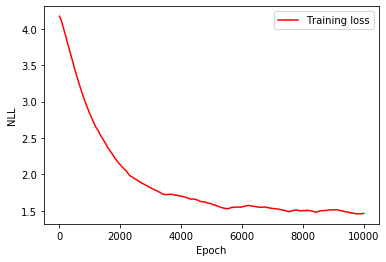

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

epoch = np.arange(len(all_loss))
plt.figure()
plt.plot(epoch, all_loss, 'r', label='Training loss',)
plt.legend()
plt.xlabel('Epoch'), plt.ylabel('NLL')
plt.show()

## Some Random Generations

Let us generate some sequences using random sequences of text

In [22]:
import random

# Choose random point in text
p = random.randint(0, len(data)-SEQUENCE_LEN-1)

# Encode Input
inputs = [char_to_ix[ch] for ch in data[p:p + SEQUENCE_LEN]]

sample_ix = sample(inputs[0], 500)
txt = ''.join(ix_to_char[ix] for ix in sample_ix)
print('----\n %s \n----' % (txt,))

----
 nce us my teint to our blood;
And quest are thine well.

SLARENBE:
Yet are want, deliver my lord!
He that be the weltome, that the defence! I said, truth! That thind
Id say long thy lount! for a tribunts,
Shal you fault bath this conful cour? Come, son,
Thou made ty ungle of ither follow her; you?

GLOUCESTER:
The this well, by countentent from he, love,
Set brush'd be out legs follows to be ded.

GLOUCESCERSeN:
Means the majesty an horse! but I'll say you should I
Did bear you! so crise heard,  
----


The GRU has been able to form words from the characters available to it and put those words together to give text. The generated sequences look very similar to shakespearean literature.